## Import modules, data and packages

In [14]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import models.road_network.create_graph as cg
import models.vehicle_models.energy_consumption as ec
import simulation.simulate_routes as sr

from pprint import pprint


In [15]:
def load_json(file_path):
    """Loads JSON data from a file."""
    with open(file_path, "r") as file:
        return json.load(file)

# Load battery, vehicle, and static data
static_data = load_json("models/vehicle_models/static_data.json")
vehicle_data = load_json("models/vehicle_models/vehicle_data.json")
battery_data = load_json("models/vehicle_models/battery_data.json")
map_data = load_json("./data_collection/data/large_net/fixed_large_dis_data.json")

# Load road network
road_network_file = './data_collection/data/large_net/large_edge_data.csv' 
road_df = pd.read_csv(road_network_file)

# Battery Parameters
BATTERY_CAPACITY = battery_data["Capacity"]  # Ah
OCV = battery_data["OCV"]
R_INT = battery_data["R_internal"]
MOTOR_EFF = vehicle_data["motor_eff"]

# ----------------------------------------
# Create Road Network Graph
# ----------------------------------------

graph = cg.create_osmnx_compatible_graph(road_network_file, debug=False)

route_test = (17585126, 2076171054)

# Weights for route selection
weights_dict = {
    'incline_weight': 2.28,
    'max_incline_weight': 0.88,
    'distance_weight': 5.29,
    'zero_start_weight': 15.0
}

In [22]:
route_obj = sr.find_route(map_data, road_df, graph, route_test[0], route_test[1], weights_dict, plot=False, weights_type='obj')
route_dis = sr.find_route(map_data, road_df, graph, route_test[0], route_test[1], weights_dict, plot=False, weights_type='distance')


def extract_route_data(route_output):
    """Extracts relevant energy and time data from a given route output."""
    total_distance, total_consumption, total_climb, detailed_results, current_list, climbs, distances, consumption_list= sr.return_route_data_complex(
        route_output, vehicle_data, static_data, MOTOR_EFF, battery_data
    )
    
    # Extract time per segment
    time_list = [
        data["time"]
        for key, value in detailed_results.items()
        if 'path' in key
        for _, data in value.items()
    ]
    
    return total_distance, current_list, time_list, total_consumption, consumption_list

# Get route data
total_distance_obj, current_list_obj, time_list_obj, total_consumption_ob, consumptions_ob = extract_route_data(route_obj)
total_distance_dis, current_list_dis, time_list_dis, total_consumption,consumptions_dis = extract_route_data(route_dis)

def calc_capacity_reduction(consumption):
    loss = consumption/OCV
    return loss

def update_capacity_with_loss(current_list, consumptions, initial_capacity, OCV):
    # Initialize the capacity list with the initial capacity
    capacity_list = [initial_capacity]
    c_rates_list = []
    
    # For each step, calculate the loss and update the capacity
    for i in range(len(consumptions)):
        # Calculate capacity loss from the consumption
        loss = calc_capacity_reduction(consumptions[i])
        
        # Update the capacity by subtracting the loss
        current_capacity = capacity_list[-1] - loss
        capacity_list.append(current_capacity)
        
        # Calculate C-rate using the current capacity (not the initial one)
        c_rate = current_list[i] / current_capacity if current_capacity > 0 else float('inf')
        c_rates_list.append(c_rate)
    
    # Remove the initial capacity as it's not associated with any consumption
    capacity_list.pop(0)
    
    return capacity_list, c_rates_list


cap_list_ob, c_rates_obj = update_capacity_with_loss(current_list_obj, consumptions_ob, BATTERY_CAPACITY, OCV)
cap_list_dis, c_rates_dis = update_capacity_with_loss(current_list_dis, consumptions_dis, BATTERY_CAPACITY, OCV)


114 114
1937.2070081701636


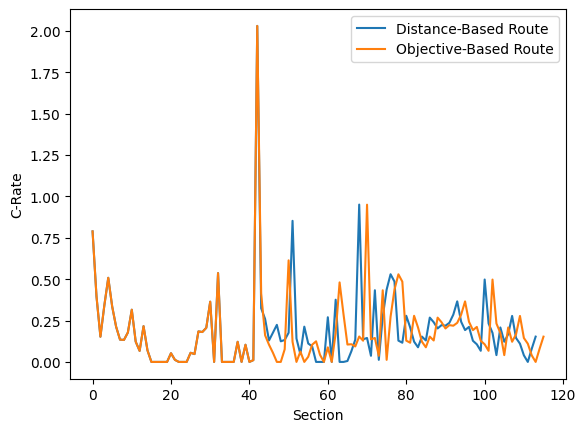

In [21]:
def plot_c_rates(c_rates_obj, c_rates_dis):
    """Plots C-rates over time for different route strategies."""
    plt.plot(range(len(c_rates_dis)), c_rates_dis, label='Distance-Based Route')
    plt.plot(range(len(c_rates_obj)), c_rates_obj, label='Objective-Based Route')
    plt.xlabel("Section")
    plt.ylabel("C-Rate")
    plt.legend()
    plt.show()

plot_c_rates(c_rates_obj, c_rates_dis)

In [36]:
# ----------------------------------------
# Capacity Loss Calculation
# ----------------------------------------
base_k = 0.200
c_rate_exp = 0.2286
charging_factor = 0.4

def compute_capacity_loss(c_rate_list, time_list, k=base_k, n=c_rate_exp):
    """
    Computes total capacity loss based on an empirical degradation model.
    
    cap_loss = k * (C-rate ^ n) * cycle_fraction
    """
    cap_losses = []
    
    for c_rate, time in zip(c_rate_list, time_list):
        cycle_fraction = (time / 3600) * c_rate  # Convert time from seconds to cycles
        cap_loss = k * (c_rate ** n) * cycle_fraction
        cap_losses.append(cap_loss)

    return sum(cap_losses)

# Calculate capacity loss
cap_loss_obj = compute_capacity_loss(c_rates_obj, time_list_obj)
cap_loss_dis = compute_capacity_loss(c_rates_dis, time_list_dis)



0.0024572601029818467


In [37]:
def EOL(cap_loss, distance):

    cap_loss_per_m = cap_loss / distance

    cap_loss_per_charge = cap_loss_per_m * 45000
    print(cap_loss_per_charge)

    print((BATTERY_CAPACITY*0.6)/cap_loss_per_charge)

EOL(cap_loss_obj, total_distance_obj)
EOL(cap_loss_dis, total_distance_dis)

0.055467682527966355
627.3923555838866
0.05848427074206462
595.0317847593543


In [19]:
# Difference in percentage
cap_loss_difference_perc = ((cap_loss_obj - cap_loss_dis) / cap_loss_obj) * 100

print(f"Capacity Loss (Objective Route): {cap_loss_obj:.6f}")
print(f"Capacity Loss (Distance Route): {cap_loss_dis:.6f}")
print(f"Percentage Difference: {cap_loss_difference_perc:.2f}%")


Capacity Loss (Objective Route): 0.000001
Capacity Loss (Distance Route): 0.000001
Percentage Difference: -4.04%


In [20]:


# ----------------------------------------
# End-of-Life Estimation
# ----------------------------------------

def estimate_EOL(cap_loss, total_distance, capacity_threshold=20, battery_capacity=BATTERY_CAPACITY):
    """
    Estimates battery End-of-Life (EOL) based on route-induced degradation.
    
    - cap_loss: Fractional capacity loss per route
    - total_distance: Distance of one route
    - capacity_threshold: % degradation threshold for EOL (default: 20%)
    - battery_capacity: Nominal capacity of the battery (Ah)
    """
    absolute_cap_loss = cap_loss * battery_capacity  # Convert to Ah
    num_routes_to_EOL = 80000 / total_distance  # Assume battery lifespan of 80,000 km
    single_charge_loss = (num_routes_to_EOL * absolute_cap_loss) / battery_capacity * 100
    num_cycles_to_EOL = capacity_threshold / single_charge_loss

    print(f"Estimated Cycles to EOL: {num_cycles_to_EOL:.2f}")
    return num_cycles_to_EOL

# Compute EOL estimates
eol_obj = estimate_EOL(cap_loss_obj, total_distance_obj)
eol_dis = estimate_EOL(cap_loss_dis, total_distance_dis)


Estimated Cycles to EOL: 3819.52
Estimated Cycles to EOL: 3567.45
